In [13]:
import pandas as pd
import numpy as np
import ChartingFunctions.plot_strategy as plt_st
import matplotlib.pyplot as plt
import Labeling.getDailyVol as gdv
import Sampling.Sampling as spl
import Labeling.TBM as tbm
import Trading.strategy as strategy
import FractDiff.fractdiff as fdiff

df = pd.read_parquet("IntradayData/BTCUSD_2020-04-07_2022-04-06.parquet")
df = df.set_index('DATE')

#Alteração para 'volume bar'
#df = spl.volume_bar(df,500) #Volume Bar

close = df['CLOSE']

Definição do Primeiro modelo

In [15]:
df['side'],s1,s2 = strategy.cross_moving_average(df['CLOSE'],50,20)
side = df['side']
print('Número total de posições..')
print(len(side[side!=0]))

Número total de posições..
25738


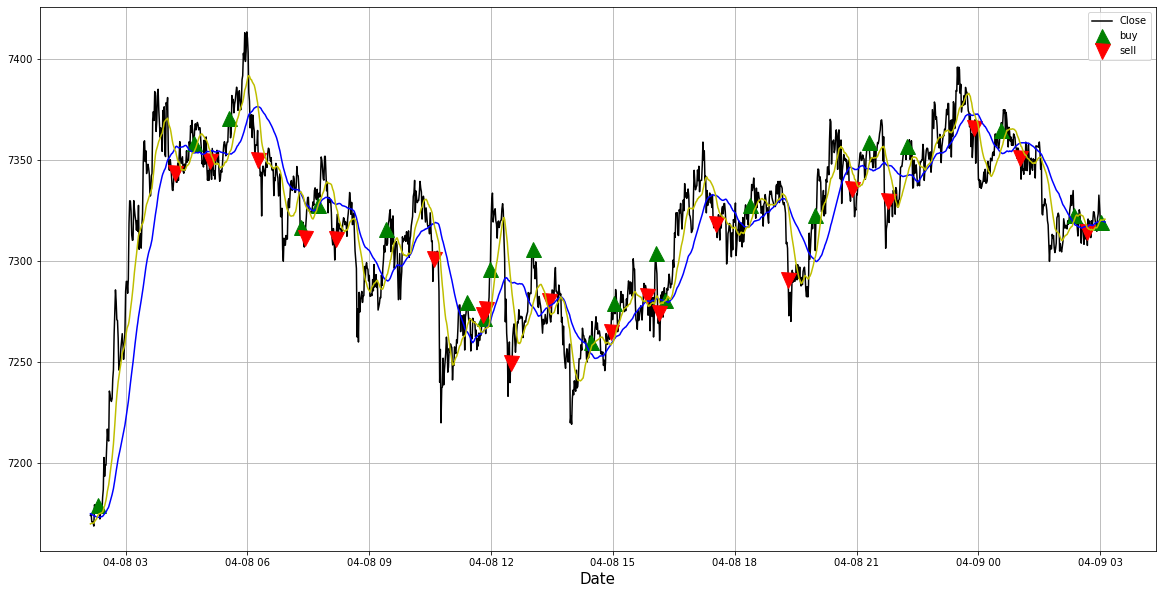

In [16]:
plt_st.plot_position(df,500,2000,s1,s2)

Avaliação do modelo (em combinação com )

In [11]:
ptSl = [1,1]
numDays = 1
minRet = 0.001

daily_std = gdv.getDailyVol(close)
trgt = daily_std.dropna()

In [12]:
tEvents = close.index

t1=close.index.searchsorted(tEvents+pd.Timedelta(days=numDays))
t1=t1[t1<close.shape[0]]
t1=pd.Series(close.index[t1],index=tEvents[:t1.shape[0]])

events = tbm.getEvents(close,tEvents,ptSl,trgt,minRet,t1,side)
bins = tbm.getBins(events, close)

Resultado do primeiro modelo...

Acurácia do primeiro modelo...
0.49484252509971116


C:\Users\THIAGO~1.SSA\AppData\Local\Temp/ipykernel_11048/2160307970.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = data[data.side!=0][data.bin.notna()]


<AxesSubplot:xlabel='DATE'>

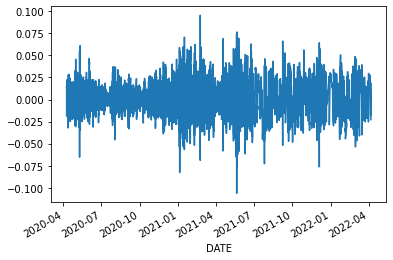

In [11]:
data = df.merge(events[['trgt','t1']] ,how='left',left_index=True,right_index=True)
data = data.merge(bins,how='left',left_index=True,right_index=True)
data = data[data.side!=0][data.bin.notna()]
print('Acurácia do primeiro modelo...')
print(data['bin'].mean())
data['ret'].plot()

....

In [12]:
data['rsi'] = strategy.rsi(data['CLOSE'],periods=14,ema=True)

In [13]:
data['OPEN'] = fdiff.ts_differencing(data['OPEN'],0.44,7)
data['HIGHT'] = fdiff.ts_differencing(data['HIGHT'],0.44,7)
data['LOW'] = fdiff.ts_differencing(data['LOW'],0.44,7)
data['CLOSE'] = fdiff.ts_differencing(data['CLOSE'],0.44,7)

In [14]:
data['CLOSE_1'] = data['CLOSE'].shift(1).fillna(0)
data['CLOSE_2'] = data['CLOSE'].shift(2).fillna(0)
data['CLOSE_3'] = data['CLOSE'].shift(3).fillna(0)
data['CLOSE_4'] = data['CLOSE'].shift(4).fillna(0)

In [15]:
data['ret'] = data['CLOSE'].diff().div(data['CLOSE'])
data['ret_1'] = data['ret'].shift(1)
data['ret_2'] = data['ret'].shift(2)
data['ret_3'] = data['ret'].shift(3)
data['ret_4'] = data['ret'].shift(4)

...

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

data = data.dropna()

# Get features at event dates
X = data[['OPEN', 'CLOSE', 'HIGHT', 'LOW', 'side', 'trgt','rsi','CLOSE_1', 'CLOSE_2', 'CLOSE_3', 'CLOSE_4','ret',
            'ret_1','ret_2','ret_3','ret_4']]
y = data['bin']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

# Setting random forest parameters
n_estimator = 1000
depth = 2
RANDOM_STATE = 0

rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', class_weight='balanced_subsample',
                            random_state=RANDOM_STATE)

# Fitting our model
rf.fit(X_train, y_train)

y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.64      0.20      0.31       960
         1.0       0.49      0.87      0.63       855

    accuracy                           0.52      1815
   macro avg       0.56      0.54      0.47      1815
weighted avg       0.57      0.52      0.46      1815

Confusion Matrix
[[193 767]
 [110 745]]

Accuracy
0.5168044077134987


_________________________________________________________

In [128]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

data = data.dropna()

# Get features at event dates
X = data[['OPEN', 'CLOSE', 'HIGHT', 'LOW', 'side', 'trgt','rsi']]
y = data['bin']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Setting random forest parameters
n_estimator = 1000
depth = 2
RANDOM_STATE = 0
MAX_SAMPLES = wght.mean()

clf = BaggingClassifier(base_estimator=SVC(), n_estimators=n_estimator, random_state=RANDOM_STATE)

# Fitting our model
clf.fit(X_train, y_train)

y_pred_clf = clf.predict_proba(X_test)[:, 1]
y_pred = clf.predict(X_test)
fpr_clf, tpr_clf, _ = roc_curve(y_test, y_pred_clf)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.49      1.00      0.66       290
         1.0       0.00      0.00      0.00       303

    accuracy                           0.49       593
   macro avg       0.24      0.50      0.33       593
weighted avg       0.24      0.49      0.32       593

Confusion Matrix
[[290   0]
 [303   0]]

Accuracy
0.48903878583473864


c:\Users\thiago.ssantos\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\thiago.ssantos\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\thiago.ssantos\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


c:\Users\thiago.ssantos\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


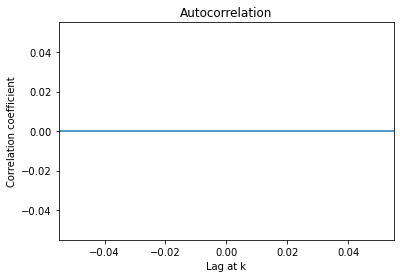

In [134]:
from statsmodels.graphics import tsaplots

fig = tsaplots.plot_acf(data["CLOSE"], lags=4)

plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

<AxesSubplot:>

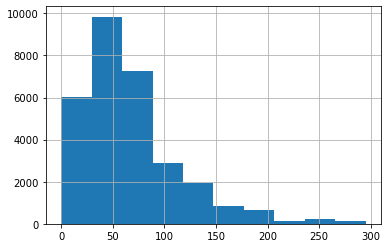

In [226]:
count_n.hist()

<AxesSubplot:xlabel='DATE'>

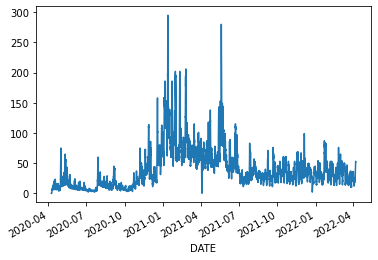

In [225]:
count_n.plot()

<AxesSubplot:>

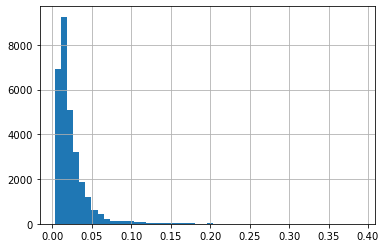

In [222]:
wght.hist(bins=50)

In [126]:
bins = tbm.getBins(events, close)

In [127]:
trgt_and_side = pd.DataFrame(index=events.index)
trgt_and_side['trgt'] = events['trgt']*events['side']

In [135]:
data = df.merge(trgt_and_side,how='inner',left_index=True,right_index=True)


In [136]:
data = data[data.trgt!=0]
bins = bins[bins.index.isin(data.index)]

In [144]:
bins.bin.mean()

0.6250954344174683

In [137]:
data = data[['OPEN', 'CLOSE', 'HIGHT', 'LOW','trgt']]

In [140]:
side_30 = strategy.bands(df['CLOSE'],30)
side_20 = strategy.bands(df['CLOSE'],20)
side_10 = strategy.bands(df['CLOSE'],10)

data = data.merge(side_30,how='left',left_index=True,right_index=True)
data = data.merge(side_20,how='left',left_index=True,right_index=True)
data = data.merge(side_10,how='left',left_index=True,right_index=True)

In [141]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

# Get features at event dates
X = data
y = bins['bin']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

# Setting random forest parameters
n_estimator = 1000
depth = 2
RANDOM_STATE = 0

rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', class_weight='balanced_subsample',
                            random_state=RANDOM_STATE)

# Fitting our model
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=2, n_estimators=1000, random_state=0)

In [142]:
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.48      0.15      0.23      2447
         1.0       0.64      0.90      0.75      4102

    accuracy                           0.62      6549
   macro avg       0.56      0.53      0.49      6549
weighted avg       0.58      0.62      0.56      6549

Confusion Matrix
[[ 370 2077]
 [ 398 3704]]

Accuracy
0.6220797068254695
